In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *
from pyiga import adaptive as adap
import json
from os.path import exists

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [3]:
#Geometries
def Lshape(deg, N):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.unit_square().translate((-1,-1)),
        geometry.unit_square().translate((-1,0)),
        geometry.unit_square()
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)
    return M

def Fichera(deg,N):
    kvs = 7*(3 * (bspline.make_knots(deg, 0.0, 1.0, N),),)
    
    #define geometry
    geos = [
        geometry.unit_cube(),
        geometry.unit_cube().translate((0,0,-1)),
        geometry.unit_cube().translate((0,-1,0)),
        geometry.unit_cube().translate((-1,0,0)),
        geometry.unit_cube().translate((-1,-1,0)),
        geometry.unit_cube().translate((-1,0,-1)),
        geometry.unit_cube().translate((0,-1,-1)),
        geometry.unit_cube().translate((-1,-1,-1))
    ]
    
    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh3D(patches)
    return M

In [8]:
def adaptive(M, f, g, u=None, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False, directory = '/home/wolfman/Pictures', return_P=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    cell_ind=[]
    patch_ind=[]
    params['u_sol']=u
    params['ux']=ux
    params['uy']=uy
    refined=[]
    P=[]
    MP = assemble.Multipatch(M, automatch = True)
    
    for i in range(maxiter):
        print(i)
        if draw:
            MP.mesh.draw(knots=1);
            plt.axis('off');
            plt.axis('scaled');
            plt.savefig(directory + '/i'+str(i)+'.png',bbox_inches='tight');
            plt.show();
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[i] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[i] = sqrt(eh.T@Mh@eh)
            H1err[i] = sqrt(eh.T@Kh@eh + L2err[i]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if i < maxiter-1:
            start=time.time()
            cell_ind.append(adap.mp_resPois2(MP,uh,f))
            patch_ind.append(np.array([(cell_ind[-1][MP.Z_ofs[p]:MP.Z_ofs[p+1]]).sum() for p in range(MP.numpatches)]))
            err_est[i] = norm(patch_ind[-1])
            #print(patch_ind[-1])
            marked_cells = adap.doerfler_mark(cell_ind[-1], theta,TOL=0.05)
            idx=np.zeros(MP.Z_ofs[-1])
            idx[marked_cells]=1
            cell_ratio = np.array([idx[MP.Z_ofs[p]:MP.Z_ofs[p+1]].sum()/MP.Z[p] for p in range(MP.numpatches)])
            err_mean = np.array([np.mean(abs(cell_ind[-1][MP.Z_ofs[p]:MP.Z_ofs[p+1]]-np.mean(cell_ind[-1][MP.Z_ofs[p]:MP.Z_ofs[p+1]]))/np.mean(cell_ind[-1][MP.Z_ofs[p]:MP.Z_ofs[p+1]])) for p in range(MP.numpatches)])
            # for p in range(MP.numpatches):
            #     x = cell_ind[-1][MP.Z_ofs[p]:MP.Z_ofs[p+1]]
            #     print(st.varian)
            marked_patches = adap.doerfler_mark(patch_ind[-1], theta, TOL=0.05)
            # for p in marked_patches:
            #     x = cell_ind[-1][MP.Z_ofs[p]:MP.Z_ofs[p+1]]
            #     print(100*np.mean(abs(x-np.mean(x))/np.mean(x)))
            #     print(cell_ind[-1][MP.Z_ofs[p]:MP.Z_ofs[p+1]])
            
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:(None if err_mean[p] > 1.5 else -1) for p in marked_patches}
            refined.append(marked_patches)
            #print(MP.numdofs)
            start = time.time()
            MP.h_refine(h_ref=marked_patches, return_P=False)
            end = time.time()
            #print("Refinement took " + str(end - start) + " seconds.")
            
            # start=time.time()
            # MP = assemble.Multipatch(M, automatch = True)
            # end = time.time()
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return MP, uh, numdofs, L2err, H1err, err_est, patch_ind

In [5]:
def uniform(M, f, g, u=None, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    MP = assemble.Multipatch(M, automatch = True)
    
    for i in range(maxiter):
        print(i)
        if draw:
            MP.mesh.draw(bwidth=1)
            plt.axis('scaled');
            plt.show()
            
        numdofs[i] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        #Kh, F = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)
        
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])
        
        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[i] = sqrt(eh.T@Mh@eh)
            H1err[i] = sqrt(eh.T@Kh@eh + L2err[i]**2)
            
        if i < maxiter-1:
            start=time.time()
            MP.h_refine(h_ref=-1)
            end=time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            MP = assemble.Multipatch(M, automatch = True)
    #MP.plot(uh)
        
    return MP, uh, numdofs, L2err, H1err

In [9]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(r, phi%(2*pi))
def u(x,y):
    r, phi = cart2pol(x,y)
    return r**(2/3)*sin(2*phi/3)
def ux(x,y):
    r, phi = cart2pol(x,y)
    return -2./3*r**(-1./3)*sin(phi/3)
def uy(x,y):
    r, phi = cart2pol(x,y)
    return 2./3*r**(-1./3)*cos(phi/3)

f=lambda x,y: 0.

In [14]:
deg=2
M = Lshape(deg,deg+1)
MP, uh, numdofs, L2err, H1err = uniform(M,f={0:f},g=u,u=u, maxiter=7, draw=False)
np.savetxt('/home/wolfman/Documents/L-shape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'_uni.txt',np.c_[[numdofs,H1err,L2err]])

Basis setup took 0.007550716400146484 seconds
0
Refinement took 0.0001380443572998047 seconds
Basis setup took 0.006582021713256836 seconds
Refinement took 0.01035308837890625 seconds.
Basis setup took 0.0066394805908203125 seconds
1
Refinement took 0.00012683868408203125 seconds
Basis setup took 0.008620977401733398 seconds
Refinement took 0.012512683868408203 seconds.
Basis setup took 0.009000539779663086 seconds
2
Refinement took 0.00013875961303710938 seconds
Basis setup took 0.015966415405273438 seconds
Refinement took 0.02122044563293457 seconds.
Basis setup took 0.018802881240844727 seconds
3
Refinement took 0.00020360946655273438 seconds
Basis setup took 0.06803250312805176 seconds
Refinement took 0.07815790176391602 seconds.
Basis setup took 0.04393148422241211 seconds
4
Refinement took 0.0001647472381591797 seconds
Basis setup took 0.14647674560546875 seconds
Refinement took 0.1564774513244629 seconds.
Basis setup took 0.14061617851257324 seconds
5
Refinement took 0.000186204

0


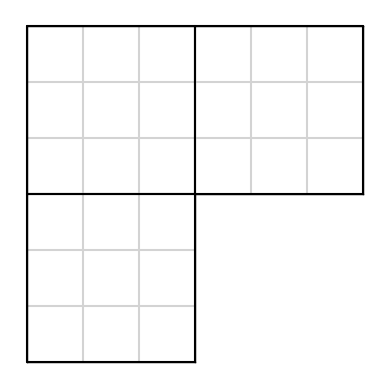

residual contributions took 0.020015954971313477 seconds.
jump contributions took 0.015100479125976562 seconds.
Estimate and Marking took 0.035424232482910156 seconds.
1


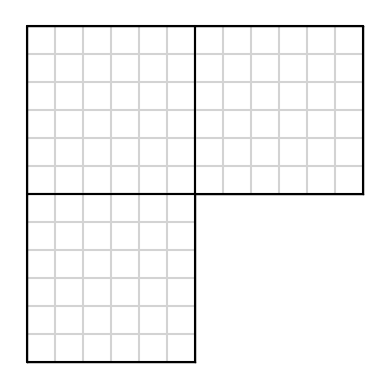

residual contributions took 0.02059030532836914 seconds.
jump contributions took 0.014996767044067383 seconds.
Estimate and Marking took 0.03588461875915527 seconds.
2


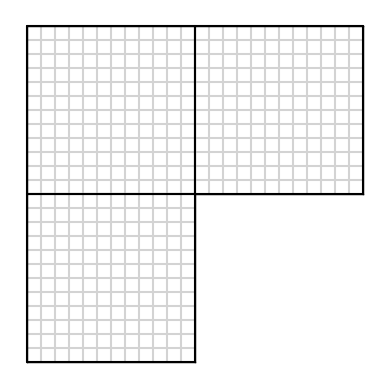

residual contributions took 0.02055835723876953 seconds.
jump contributions took 0.014994144439697266 seconds.
Estimate and Marking took 0.035881996154785156 seconds.
3


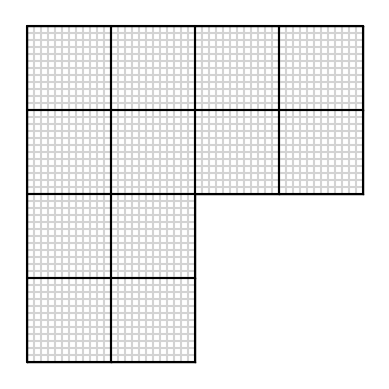

residual contributions took 0.07740187644958496 seconds.
jump contributions took 0.12557029724121094 seconds.
Estimate and Marking took 0.2036113739013672 seconds.
4


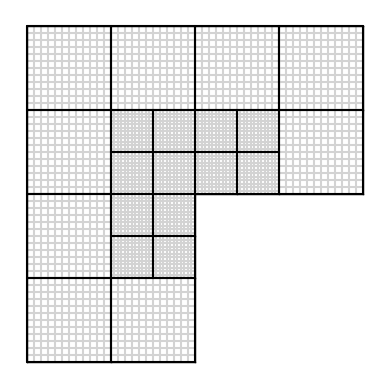

residual contributions took 0.13437461853027344 seconds.
jump contributions took 0.28084373474121094 seconds.
Estimate and Marking took 0.41654300689697266 seconds.
5


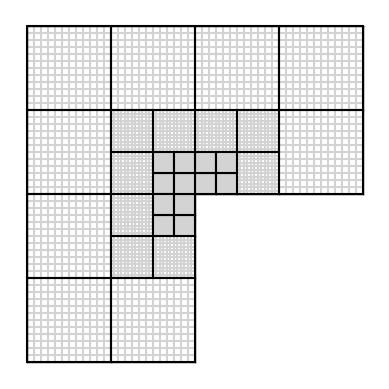

residual contributions took 0.19146084785461426 seconds.
jump contributions took 0.43921542167663574 seconds.
Estimate and Marking took 0.6322908401489258 seconds.
6


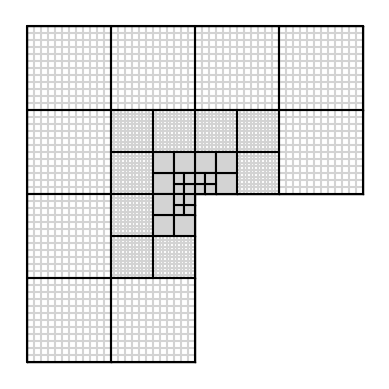

residual contributions took 0.2484149932861328 seconds.
jump contributions took 0.6015164852142334 seconds.
Estimate and Marking took 0.851799488067627 seconds.
7


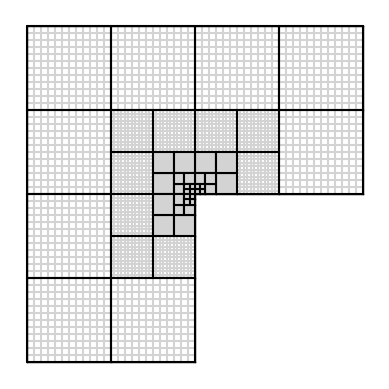

residual contributions took 0.3011646270751953 seconds.
jump contributions took 0.7577133178710938 seconds.
Estimate and Marking took 1.0609955787658691 seconds.
8


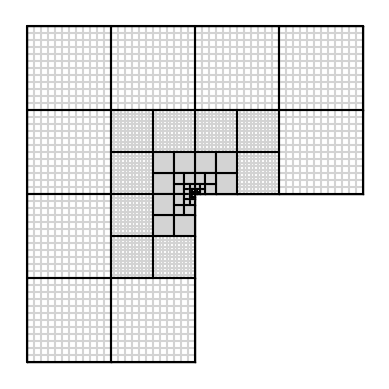

residual contributions took 0.357205867767334 seconds.
jump contributions took 0.9167709350585938 seconds.
Estimate and Marking took 1.2787013053894043 seconds.
9


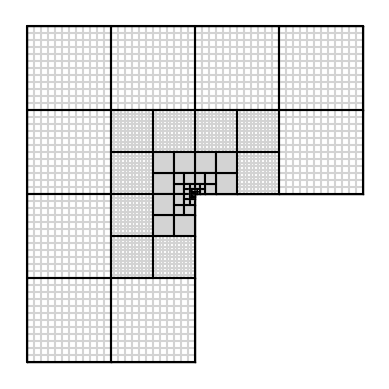

residual contributions took 0.4131450653076172 seconds.
jump contributions took 1.0796983242034912 seconds.
Estimate and Marking took 1.495706558227539 seconds.
10


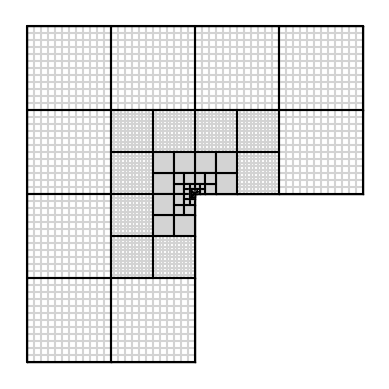

residual contributions took 0.46881604194641113 seconds.
jump contributions took 1.2338433265686035 seconds.
Estimate and Marking took 1.7060019969940186 seconds.
11


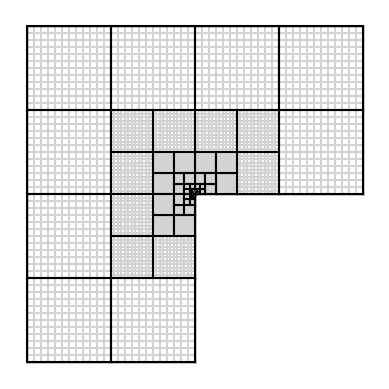

residual contributions took 0.5240585803985596 seconds.
jump contributions took 1.3904333114624023 seconds.
Estimate and Marking took 1.918055534362793 seconds.
12


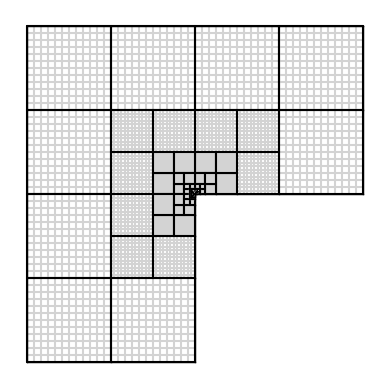

residual contributions took 0.5786268711090088 seconds.
jump contributions took 1.5605895519256592 seconds.
Estimate and Marking took 2.143571615219116 seconds.
13


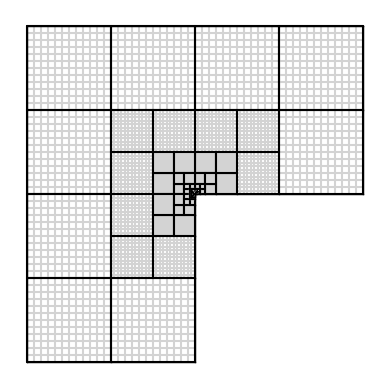

residual contributions took 0.6406798362731934 seconds.
jump contributions took 1.7095725536346436 seconds.
Estimate and Marking took 2.3545281887054443 seconds.
14


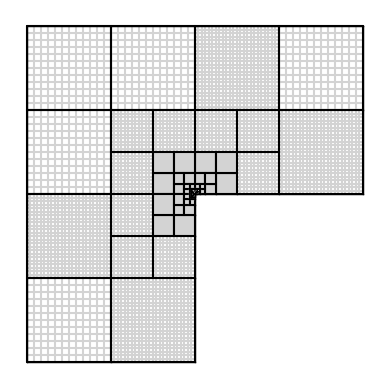

residual contributions took 0.719658374786377 seconds.
jump contributions took 1.8839309215545654 seconds.
Estimate and Marking took 2.608389139175415 seconds.
4 (KnotVector(array([0.5    , 0.5    , 0.5    , 0.51042, 0.52083, 0.53125, 0.54167, 0.55208, 0.5625 , 0.57292, 0.58333, 0.59375, 0.60417, 0.61458, 0.625  , 0.63542, 0.64583, 0.65625, 0.66667, 0.67708, 0.6875 , 0.69792, 0.70833, 0.71875, 0.72917, 0.73958, 0.75   , 0.76042, 0.77083, 0.78125, 0.79167, 0.80208, 0.8125 , 0.82292, 0.83333, 0.84375, 0.85417, 0.86458, 0.875  , 0.88542, 0.89583, 0.90625, 0.91667, 0.92708, 0.9375 , 0.94792, 0.95833, 0.96875, 0.97917, 0.98958, 1.     , 1.     , 1.     ]), 2),) 5 (KnotVector(array([0.5    , 0.5    , 0.5    , 0.52083, 0.54167, 0.5625 , 0.58333, 0.60417, 0.625  , 0.64583, 0.66667, 0.6875 , 0.70833, 0.72917, 0.75   , 0.75   , 0.75   ]), 2),)
interface coupling not possible
7 (KnotVector(array([0.     , 0.     , 0.     , 0.01042, 0.02083, 0.03125, 0.04167, 0.05208, 0.0625 , 0.07292, 0.08333, 0.

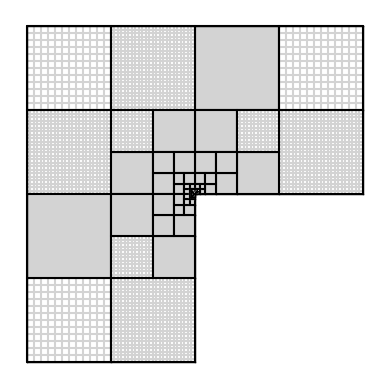

residual contributions took 0.74930739402771 seconds.
jump contributions took 2.0333290100097656 seconds.
Estimate and Marking took 2.7884628772735596 seconds.
129 (KnotVector(array([0.5    , 0.5    , 0.5    , 0.50521, 0.51042, 0.51562, 0.52083, 0.52604, 0.53125, 0.53646, 0.54167, 0.54688, 0.55208, 0.55729, 0.5625 , 0.56771, 0.57292, 0.57812, 0.58333, 0.58854, 0.59375, 0.59896, 0.60417, 0.60938, 0.61458, 0.61979, 0.625  , 0.63021, 0.63542, 0.64062, 0.64583, 0.65104, 0.65625, 0.66146, 0.66667, 0.67188, 0.67708, 0.68229, 0.6875 , 0.69271, 0.69792, 0.70312, 0.70833, 0.71354, 0.71875, 0.72396, 0.72917, 0.73438, 0.73958, 0.74479, 0.75   , 0.75   , 0.75   ]), 2),) 136 (KnotVector(array([0.625  , 0.625  , 0.625  , 0.63542, 0.64583, 0.65625, 0.66667, 0.67708, 0.6875 , 0.69792, 0.70833, 0.71875, 0.72917, 0.73958, 0.75   , 0.75   , 0.75   ]), 2),)
interface coupling not possible
5 (KnotVector(array([0.5    , 0.5    , 0.5    , 0.51042, 0.52083, 0.53125, 0.54167, 0.55208, 0.5625 , 0.57292, 0.58333

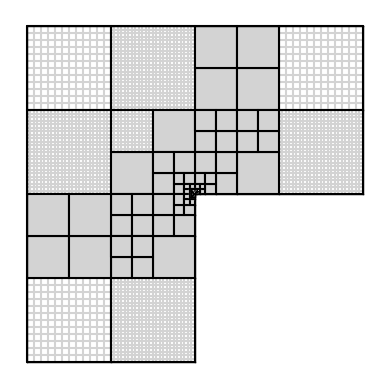

residual contributions took 0.8740332126617432 seconds.
jump contributions took 2.3693299293518066 seconds.
Estimate and Marking took 3.2778446674346924 seconds.
126 (KnotVector(array([0.25   , 0.25   , 0.25   , 0.25521, 0.26042, 0.26562, 0.27083, 0.27604, 0.28125, 0.28646, 0.29167, 0.29688, 0.30208, 0.30729, 0.3125 , 0.31771, 0.32292, 0.32812, 0.33333, 0.33854, 0.34375, 0.34896, 0.35417, 0.35938, 0.36458, 0.36979, 0.375  , 0.38021, 0.38542, 0.39062, 0.39583, 0.40104, 0.40625, 0.41146, 0.41667, 0.42188, 0.42708, 0.43229, 0.4375 , 0.44271, 0.44792, 0.45312, 0.45833, 0.46354, 0.46875, 0.47396, 0.47917, 0.48438, 0.48958, 0.49479, 0.5    , 0.5    , 0.5    ]), 2),) 133 (KnotVector(array([0.25   , 0.25   , 0.25   , 0.26042, 0.27083, 0.28125, 0.29167, 0.30208, 0.3125 , 0.32292, 0.33333, 0.34375, 0.35417, 0.36458, 0.375  , 0.375  , 0.375  ]), 2),)
interface coupling not possible
126 (KnotVector(array([0.25   , 0.25   , 0.25   , 0.25521, 0.26042, 0.26562, 0.27083, 0.27604, 0.28125, 0.28646, 0.2

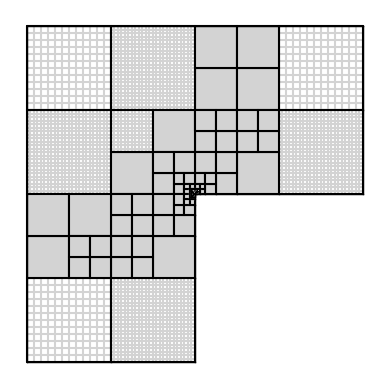

residual contributions took 0.903109073638916 seconds.
jump contributions took 2.4307610988616943 seconds.
Estimate and Marking took 3.3421123027801514 seconds.
145 (KnotVector(array([0.375  , 0.375  , 0.375  , 0.38021, 0.38542, 0.39062, 0.39583, 0.40104, 0.40625, 0.41146, 0.41667, 0.42188, 0.42708, 0.43229, 0.4375 , 0.4375 , 0.4375 ]), 2),) 147 (KnotVector(array([0.375  , 0.375  , 0.375  , 0.3776 , 0.38021, 0.38281, 0.38542, 0.38802, 0.39062, 0.39323, 0.39583, 0.39844, 0.40104, 0.40365, 0.40625, 0.40885, 0.41146, 0.41406, 0.41667, 0.41927, 0.42188, 0.42448, 0.42708, 0.42969, 0.43229, 0.4349 , 0.4375 , 0.4401 , 0.44271, 0.44531, 0.44792, 0.45052, 0.45312, 0.45573, 0.45833, 0.46094, 0.46354, 0.46615, 0.46875, 0.47135, 0.47396, 0.47656, 0.47917, 0.48177, 0.48438, 0.48698, 0.48958, 0.49219, 0.49479, 0.4974 , 0.5    , 0.5    , 0.5    ]), 2),)
interface coupling not possible
126 (KnotVector(array([0.25   , 0.25   , 0.25   , 0.2526 , 0.25521, 0.25781, 0.26042, 0.26302, 0.26562, 0.26823, 0.27

ValueError: negative column index found

In [10]:
deg=2
M = Lshape(deg,deg+1)
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est, err_ind = adaptive(M, f={0:f}, g=u, u=u, draw=True, maxiter=20, theta=0.9, directory = '/home/wolfman/Pictures/Lshape_p'+ str(deg))
#M.draw()
np.savetxt('/home/wolfman/Documents/L-shape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'.txt', np.c_[[numdofs_a,H1err_a,L2err_a,err_est]])

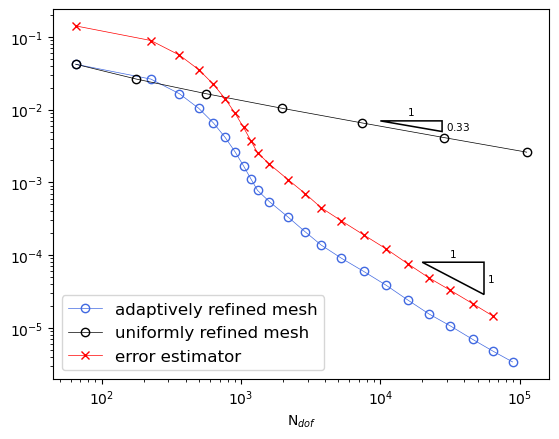

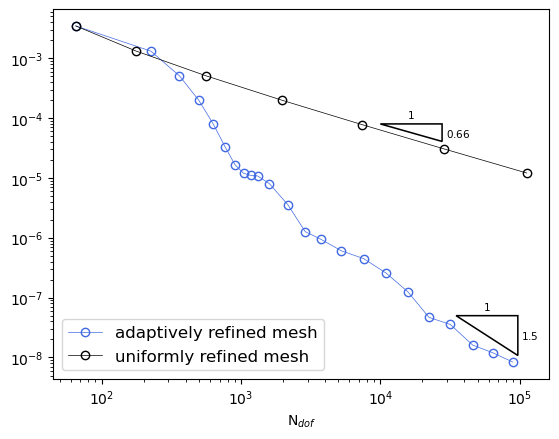

In [126]:
deg=2
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('Lp'+str(deg)+'n'+str(deg+1)+'.txt').reshape((4,23))

fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptively refined mesh','uniformly refined mesh','error estimator'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(2*1e4,0.8*1e-4),2, int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e4,0.7*1e-2),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
# ax.set_xlim([1e1,1e5]);
# ax.set_ylim([1e-8,0.3]);
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(3.5*1e4,0.5*1e-7),2,slope=(deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e4,0.8*1e-4),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv.pdf', bbox_inches='tight')
plt.show()

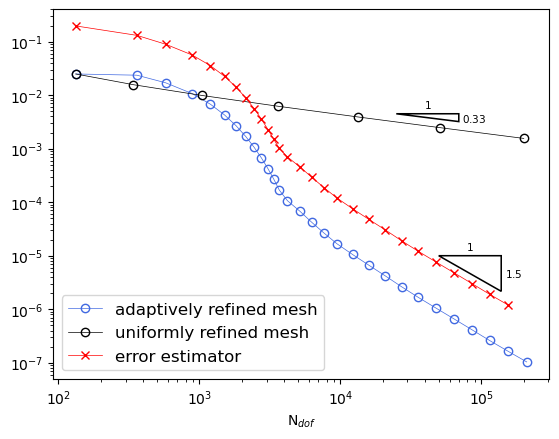

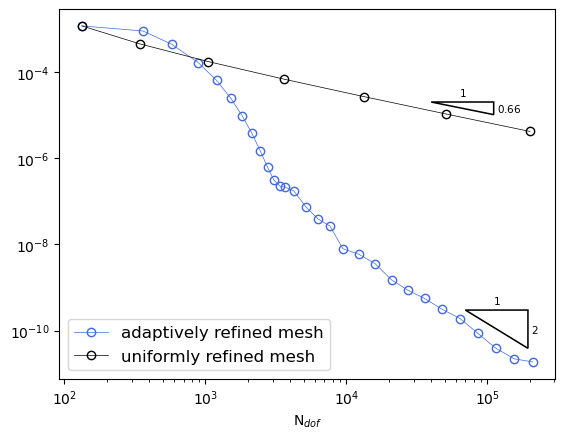

In [ ]:
deg=3
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('Lp'+str(deg)+'n'+str(deg+1)+'.txt').reshape((4,29))

fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(1) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptively refined mesh','uniformly refined mesh','error estimator'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(0.5*1e5,1e-5),2,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(0.25*1e5,4.5*1e-3),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
# ax.set_xlim([1,1e7]);
# ax.set_ylim([1e-8,0.3]);
# axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(0.7*1e5,0.3*1e-9),2,slope=2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(4*1e4,2*1e-5),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv.pdf', bbox_inches='tight')
plt.show()

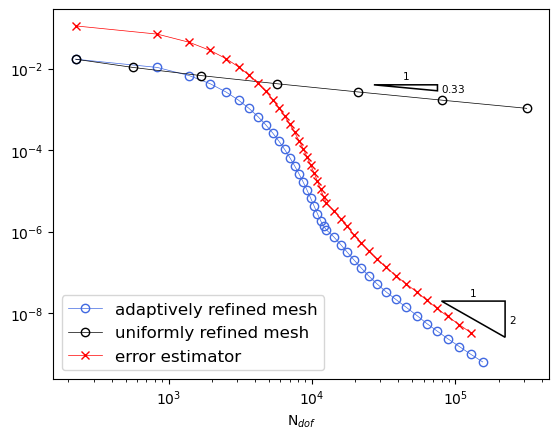

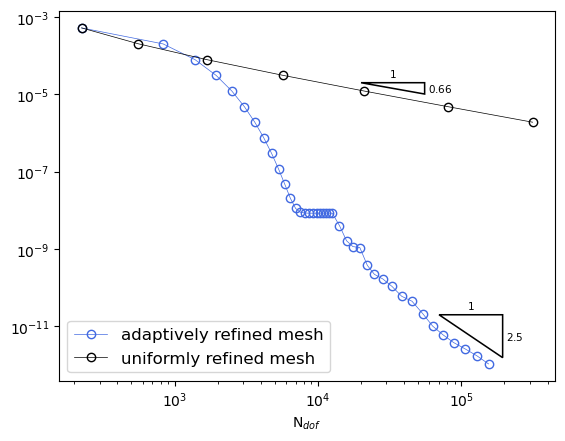

In [130]:
deg=4
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('Lp'+str(deg)+'n'+str(deg+1)+'.txt').reshape((4,40))

fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(1) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
#plt.legend(['adaptive','uniform','error estimator'],loc='lower left',prop={'size': 12})
plt.legend(['adaptively refined mesh','uniformly refined mesh','error estimator'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(0.8*1e5,0.2*1e-7),2,2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(2.7*1e4,0.4*1e-2),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(0.7*1e5,0.2*1e-10),2,slope=2.5,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(2*1e4,2*1e-5),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv.pdf', bbox_inches='tight')
plt.show()